In [2]:
import pandas as pd
import numpy as np
url="/content/telco.csv"
df=pd.read_csv(url)
df=pd.DataFrame(df)
df.head(3)

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer


In [3]:
df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Population                              0
Quarter                                 0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

In [4]:
df.columns

Index(['Customer ID', 'Gender', 'Age', 'Under 30', 'Senior Citizen', 'Married',
       'Dependents', 'Number of Dependents', 'Country', 'State', 'City',
       'Zip Code', 'Latitude', 'Longitude', 'Population', 'Quarter',
       'Referred a Friend', 'Number of Referrals', 'Tenure in Months', 'Offer',
       'Phone Service', 'Avg Monthly Long Distance Charges', 'Multiple Lines',
       'Internet Service', 'Internet Type', 'Avg Monthly GB Download',
       'Online Security', 'Online Backup', 'Device Protection Plan',
       'Premium Tech Support', 'Streaming TV', 'Streaming Movies',
       'Streaming Music', 'Unlimited Data', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charge', 'Total Charges', 'Total Refunds',
       'Total Extra Data Charges', 'Total Long Distance Charges',
       'Total Revenue', 'Satisfaction Score', 'Customer Status', 'Churn Label',
       'Churn Score', 'CLTV', 'Churn Category', 'Churn Reason'],
      dtype='object')

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load the data
url = "/content/telco.csv"
df = pd.read_csv(url)

# Select relevant columns
features = ['Total Revenue', 'Satisfaction Score', 'Total Charges', 'Tenure in Months', 'Number of Referrals', 'Avg Monthly GB Download']
target = 'Churn Label'

# Handle missing values (assuming 'most frequent' strategy for simplicity)
df = df.fillna(df.mode().iloc[0])

# Extract features and target variable
X = df[features].values
y = df[target].values

# Encode target variable if it's categorical
y = np.where(y == 'Yes', 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_dim = X_train.shape[1]
model = MLP(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred.extend(predicted.numpy())
        y_true.extend(labels.numpy())

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))

# Plot training & validation loss values
import matplotlib.pyplot as plt

# Assuming the loss values are stored during training for plotting
loss_values = []

# Training loop with loss tracking
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_values.append(epoch_loss / len(train_loader))
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

plt.plot(range(num_epochs), loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Epoch [10/50], Loss: 0.0000
Epoch [20/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0000
Epoch [40/50], Loss: 0.0001
Epoch [50/50], Loss: 0.1600


TypeError: iteration over a 0-d array

Epoch [10/50], Loss: 0.1320
Epoch [20/50], Loss: 0.1236
Epoch [30/50], Loss: 0.1225
Epoch [40/50], Loss: 0.1177
Epoch [50/50], Loss: 0.1299
Accuracy: 0.9382540809084458
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      1009
           1       0.96      0.81      0.88       400

    accuracy                           0.94      1409
   macro avg       0.95      0.90      0.92      1409
weighted avg       0.94      0.94      0.94      1409



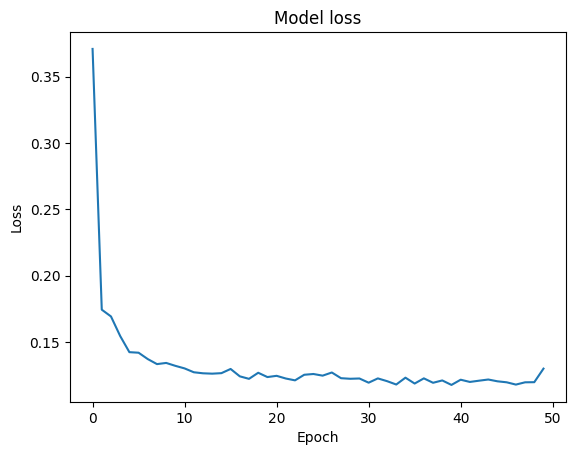

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Load the data
url = "/content/telco.csv"
df = pd.read_csv(url)

# Select relevant columns
features = ['Total Revenue', 'Satisfaction Score', 'Total Charges', 'Tenure in Months', 'Number of Referrals', 'Avg Monthly GB Download']
target = 'Churn Label'

# Handle missing values (assuming 'most frequent' strategy for simplicity)
df = df.fillna(df.mode().iloc[0])

# Extract features and target variable
X = df[features].values
y = df[target].values

# Encode target variable if it's categorical
y = np.where(y == 'Yes', 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

input_dim = X_train.shape[1]
model = MLP(input_dim)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
model.train()

loss_values = []  # To store the loss values

for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_values.append(epoch_loss / len(train_loader))
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# Evaluating the model
model.eval()
with torch.no_grad():
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze().cpu().numpy()
        predicted = (outputs > 0.5).astype(int)
        if predicted.ndim == 0:  # Handle the case where there's a single prediction
            predicted = np.array([predicted])
        y_pred.extend(predicted.tolist())  # Ensure predicted is always a list

        # Ensure labels is always a list
        labels_list = labels.cpu().numpy().squeeze().astype(int)
        if labels_list.ndim == 0:
            labels_list = np.array([labels_list])
        y_true.extend(labels_list.tolist())  # Ensure y_true is always a list

print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
print(classification_report(y_true, y_pred))

# Plot training & validation loss values
plt.plot(range(num_epochs), loss_values)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()